# Fashion-MNIST

In [2]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

## Data preprocessing

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(60000, 785)

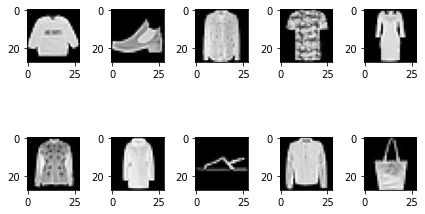

In [3]:
# 1. Raw Data Loading
df = pd.read_csv('fashion-mnist/fashion-mnist_train.csv')
display(df.head(), df.shape) # (60000, 785)

# 2. 결측치, 이상치 없음

# 3. 이미지 데이터(픽셀 정보) 확인
img_data = df.drop('label', axis=1, inplace=False).values # 2차원 ndarray

fig = plt.figure()
fig_arr = list()
for n in range(10):
    fig_arr.append(fig.add_subplot(2,5,n+1))
    fig_arr[n].imshow(img_data[n].reshape(28,28), cmap='gray') # 행 픽셀 정보(2차원 ndarray) + cmap
plt.tight_layout()
plt.show()

# 4. data split (7:3)
x_data_train, x_data_test, t_data_train, t_data_test = \
train_test_split(df.drop('label', axis=1, inplace=False), df['label'],
                 test_size=0.3, random_state=0)

# 5. 정규화 처리 (x_data)
scaler = MinMaxScaler()
scaler.fit(x_data_train)
x_data_train_norm = scaler.transform(x_data_train)

scaler.fit(x_data_test)
x_data_test_norm = scaler.transform(x_data_test)

# 6. One-hot Encoding (t_data)
sess = tf.Session()
t_data_train_onehot = sess.run(tf.one_hot(t_data_train, depth=10))
t_data_test_onehot = sess.run(tf.one_hot(t_data_test, depth=10))

## Multinomial Classification_TF1.15 (85%)

### Tensorflow Graph

In [4]:
# Placeholder
X = tf.placeholder(shape=[None,784], dtype=tf.float32)
T = tf.placeholder(shape=[None,10], dtype=tf.float32)

# Weight, bias
# He's initialization
W = tf.get_variable('weight', shape=[784,10],
                    initializer=tf.contrib.layers.variance_scaling_initializer())
b = tf.Variable(tf.random.normal([10]))

# Hypothesis
logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit)

# Loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit, labels=T))

# Gradient descent algorithm
train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Learning

In [5]:
# Batch
num_of_epoch = 1000
batch_size = 512

# Learning
def run_train(sess, train_x, train_t): # x_data_train_norm, t_data_train_onehot
    print('=====START LEARNING=====')
    
    # 초기화
    sess.run(tf.global_variables_initializer())
    
    # 반복학습
    for step in range(num_of_epoch):
        total_batch = int(train_x.shape[0] / batch_size)
        
        for i in range(total_batch):
            batch_x = train_x[i*batch_size:(i+1)*batch_size] 
            batch_t = train_t[i*batch_size:(i+1)*batch_size]
            _, loss_val = sess.run([train, loss], feed_dict={X: batch_x, T: batch_t})
        ## 여기까지 1 epoch
            
        if step % 100 == 0:
            print('Loss: {}'.format(loss_val))
    
    print('=====FINISH LEARNING=====')

### Accuracy

In [6]:
# Accuracy
predict = tf.argmax(H, 1) 
correct = tf.equal(predict, tf.argmax(T, 1)) 
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32)) 

### Validation

In [7]:
# K-fold Cross Validation
cv = 5      
results = [] 

kf = KFold(n_splits=cv, shuffle=True) 

for training_idx, validation_idx in kf.split(x_data_train_norm): 
    
    training_x = x_data_train_norm[training_idx] 
    training_t = t_data_train_onehot[training_idx]
    
    validation_x = x_data_train_norm[validation_idx]
    validation_t = t_data_train_onehot[validation_idx]
    
    # 1. training data로 learning
    run_train(sess, training_x, training_t)
    
    # 2. testing data로 validation: #1에서 만든 학습모델에 대한 정확도(성능평가) 측정
    results.append(sess.run(accuracy, feed_dict={X:validation_x, T: validation_t}))
    
print('측정한 각 Fold의 정확도: {}'.format(results))

final_acc = np.mean(results)
print('K-Fold Validation을 통한 우리 모델의 최종 Accuracy: {}'.format(final_acc))

=====START LEARNING=====
Loss: 0.7784887552261353
Loss: 0.3712570071220398
Loss: 0.3552640676498413
Loss: 0.34664300084114075
Loss: 0.3405899703502655
Loss: 0.3358854055404663
Loss: 0.33202889561653137
Loss: 0.3287571668624878
Loss: 0.3259124159812927
Loss: 0.3233928084373474
=====FINISH LEARNING=====
=====START LEARNING=====
Loss: 0.8058885335922241
Loss: 0.3815992772579193
Loss: 0.36319252848625183
Loss: 0.35308563709259033
Loss: 0.3462251126766205
Loss: 0.3411380648612976
Loss: 0.33716273307800293
Loss: 0.33393678069114685
Loss: 0.3312377333641052
Loss: 0.32892054319381714
=====FINISH LEARNING=====
=====START LEARNING=====
Loss: 0.7915610074996948
Loss: 0.35549867153167725
Loss: 0.33923637866973877
Loss: 0.33153021335601807
Loss: 0.3266356885433197
Loss: 0.3231043219566345
Loss: 0.3203621208667755
Loss: 0.3181267976760864
Loss: 0.3162408471107483
Loss: 0.3146085739135742
=====FINISH LEARNING=====
=====START LEARNING=====
Loss: 0.757597804069519
Loss: 0.39011913537979126
Loss: 0.3727

### Evaluation

In [8]:
run_train(sess, training_x, training_t)
final_accuracy = sess.run(accuracy, feed_dict={X: x_data_test_norm, T: t_data_test_onehot})
print('우리 모델의 최종 정확도: {}'.format(final_accuracy))
print('\n')

# classification_report
predict_data = sess.run(predict, feed_dict={X: x_data_test_norm, T: t_data_test_onehot})
final_testing = classification_report(t_data_test, predict_data)
print(final_testing)

=====START LEARNING=====
Loss: 0.9176501631736755
Loss: 0.409595251083374
Loss: 0.3898887038230896
Loss: 0.3793260455131531
Loss: 0.3721388280391693
Loss: 0.36678728461265564
Loss: 0.3625825345516205
Loss: 0.3591462969779968
Loss: 0.3562515676021576
Loss: 0.3537551164627075
=====FINISH LEARNING=====
우리 모델의 최종 정확도: 0.8531666398048401


              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1799
           1       0.98      0.97      0.97      1843
           2       0.71      0.81      0.76      1808
           3       0.85      0.88      0.87      1849
           4       0.76      0.75      0.75      1765
           5       0.94      0.93      0.93      1786
           6       0.67      0.55      0.60      1787
           7       0.92      0.93      0.92      1789
           8       0.95      0.94      0.95      1795
           9       0.95      0.94      0.95      1779

    accuracy                           0.85     18000
   macro avg 

### Testing

In [9]:
test_raw_df = pd.read_csv('fashion-mnist/fashion-mnist_test.csv')
x_test = test_raw_df.drop('label', axis=1, inplace=False)
t_test = test_raw_df['label']

# normalization
x_test_norm = scaler.transform(x_test)

# prediction
test_result = sess.run(predict, feed_dict={X: x_test_norm})

# classification_report
final_result = classification_report(t_test, test_result)
print(final_result)

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1000
           1       0.97      0.98      0.97      1000
           2       0.73      0.80      0.77      1000
           3       0.86      0.88      0.87      1000
           4       0.78      0.78      0.78      1000
           5       0.93      0.92      0.92      1000
           6       0.68      0.56      0.61      1000
           7       0.91      0.92      0.91      1000
           8       0.95      0.94      0.94      1000
           9       0.93      0.94      0.94      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

